# Walmart Sales

### Metadata

**Dataset**: https://www.kaggle.com/datasets/yasserh/walmart-dataset?select=Walmart.csv

**Licence**: CC0: Public Domain

**About the dataset**

This is the historical data that covers sales from 2010-02-05 to 2012-11-01, in the file WalmartStoresales. Within this file you will find the following fields:

- **Store**: the store number
- **Date**: the week of sales
- **Weekly_Sales**: sales for the given store
- **Holiday_Flag**: whether the week is a special holiday - week 1 – Holiday week 0 – Non-holiday week
- **Temperature**: Temperature on the day of sale
- **Fuel_Price**: Cost of fuel in the region
- **CPI**: Prevailing consumer price index. Obtained by comparing, over time, the cost of a fixed basket of goods and services purchased by consumers. 
- **Unemployment**: Prevailing unemployment rate

<br>

**Holiday Events** 

- **Super Bowl**: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- **Labour Day**: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- **Thanksgiving**: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- **Christmas**: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

<br>

### Problem

The Walmart dataset contains the number of sales per week from 2010 to 2012 by store. Also, it has the average of other external data, like temperature, fuel price, and Unemployment index, among others. Based on that:

**Which of the features are most significant for weekly sales predictions?**

### Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error
import datetime
from numpy import array

## 01 Data Preparation

### 01.1 Querying the data

#### Load data from csv file

In [ ]:
url = 'https://raw.githubusercontent.com/bascr/walmart-sales/main/dataset/walmart-sales.csv'
dataset = pd.read_csv(url)
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%d-%m-%Y')
dataset

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667


#### Descriptive analysis

How many rows and columns does the dataset have?

In [ ]:
number_row, number_columns = dataset.shape
print(f'This dataset has {number_row} row and {number_columns} columns.')

This dataset has 6435 row and 8 columns.


Considering only the numerical features, what are their basic statistics values?

In [ ]:
numerical_features = dataset.copy()
numerical_features = numerical_features.drop(columns=['Store', 'Holiday_Flag'])
numerical_features.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
count,6435.00,6435.00,6435.00,6435.00,6435.00
mean,1046964.88,60.66,3.36,171.58,8.00
std,564366.62,18.44,0.46,39.36,1.88
min,209986.25,-2.06,2.47,126.06,3.88
25%,553350.10,47.46,2.93,131.74,6.89
50%,960746.04,62.67,3.44,182.62,7.87
75%,1420158.66,74.94,3.73,212.74,8.62
max,3818686.45,100.14,4.47,227.23,14.31


#### Plot the main features

**Sales By Year**

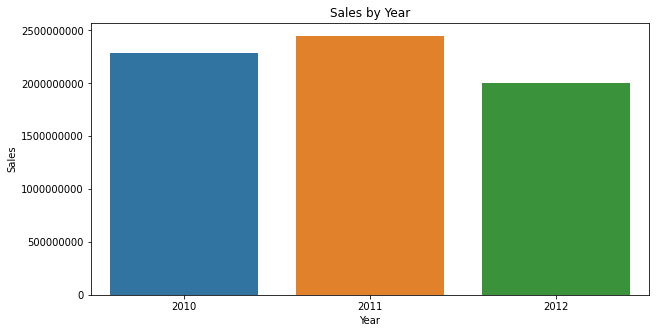

In [ ]:
yearly_sales = dataset.groupby([dataset.Date.dt.to_period('Y')])['Weekly_Sales'].sum()
yearly_sales = pd.DataFrame(yearly_sales)
yearly_sales = yearly_sales.reset_index()
plt.figure(figsize=(10,5))
plt.ticklabel_format(style='plain', axis='y')
sns.barplot(data=yearly_sales, x='Date', y='Weekly_Sales')
plt.title('Sales by Year')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

**Sales By Month**

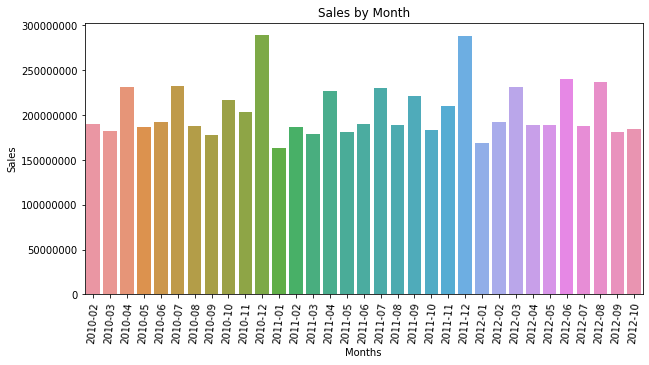

In [ ]:
monthly_sales = dataset.groupby([dataset.Date.dt.to_period('M')])['Weekly_Sales'].sum()
monthly_sales = pd.DataFrame(monthly_sales)
monthly_sales = monthly_sales.reset_index()
plt.figure(figsize=(10,5))
plt.xticks(rotation=85)
plt.ticklabel_format(style='plain', axis='y')
sns.barplot(data=monthly_sales, x='Date', y='Weekly_Sales')
plt.title('Sales by Month')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.show()


**Weekly Sales**

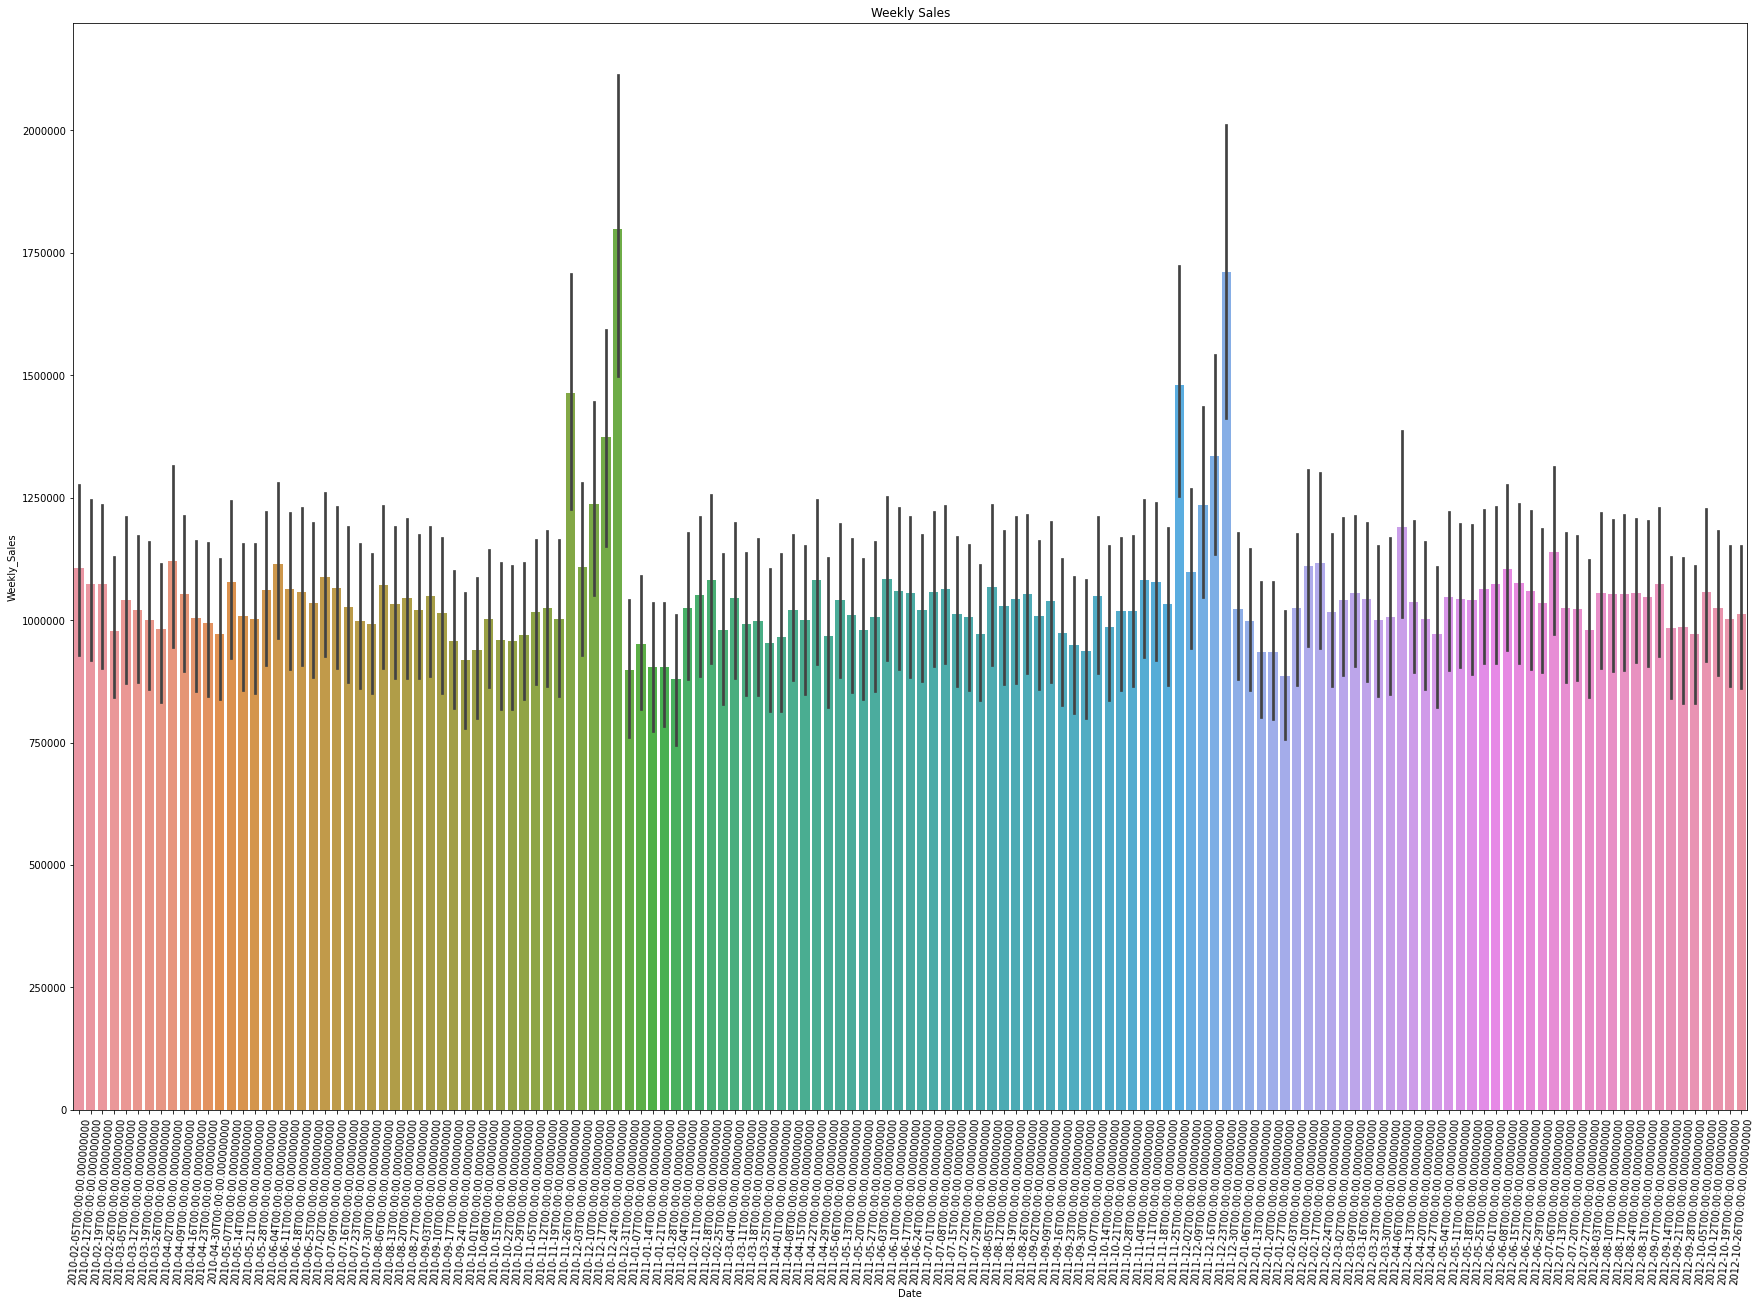

In [ ]:
plt.figure(figsize=(30,20))
plt.xticks(rotation=85)
plt.ticklabel_format(style='plain', axis='y')
sns.barplot(data=dataset, x='Date', y='Weekly_Sales')
plt.title('Weekly Sales')
plt.show()

The graph shows some peaks in sales. What are those weeks and why did people make more purchases?

In [ ]:
desc_sorted_dataset = dataset.copy()
desc_sorted_dataset = desc_sorted_dataset.sort_values(by='Weekly_Sales', ascending=False)
desc_sorted_dataset.head(20)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
1905,14,2010-12-24,3818686.45,0,30.59,3.141,182.544590,8.724
2763,20,2010-12-24,3766687.43,0,25.17,3.141,204.637673,7.484
1333,10,2010-12-24,3749057.69,0,57.06,3.236,126.983581,9.003
527,4,2011-12-23,3676388.98,0,35.92,3.103,129.984548,5.143
1762,13,2010-12-24,3595903.20,0,34.90,2.846,126.983581,7.795
1814,13,2011-12-23,3556766.03,0,24.76,3.186,129.984548,6.392
2815,20,2011-12-23,3555371.03,0,40.19,3.389,212.236040,7.082
475,4,2010-12-24,3526713.39,0,43.21,2.887,126.983581,7.127
1385,10,2011-12-23,3487986.89,0,48.36,3.541,129.984548,7.874
189,2,2010-12-24,3436007.68,0,49.97,2.886,211.064660,8.163


The weeks when Walmart had significant peaks in sales were in the last week of November and the second last week of December. Those correspond to Thanksgiving and Christmas week, respectively.

A selection of data from one store and using a scatter graph helps to visualize a linear relationship between the variables. As it is shown in the graph there is a linear relation between Temperature, Fuel Price and the Prevailing Consumer Price Index (CPI). These features are going to be evaluated to predict weekly sales, that means, the target.

In [ ]:
def plot_by_store(store_number):
  """
  Plot a scatter graph based on data from a particular store.

  Parameters
  ---------
  store_number: int
    number of the store

  Returns
  ----------
  None
  """

  store_data = dataset.copy()
  store_data = store_data[store_data['Store'] == store_number]
  store_data = store_data.drop(columns=['Store', 'Holiday_Flag'])
  sns.pairplot(store_data, kind='reg', plot_kws={'line_kws': { 'color': 'cyan'}, 'scatter_kws': {'alpha': 0.5}})
  plt.show()


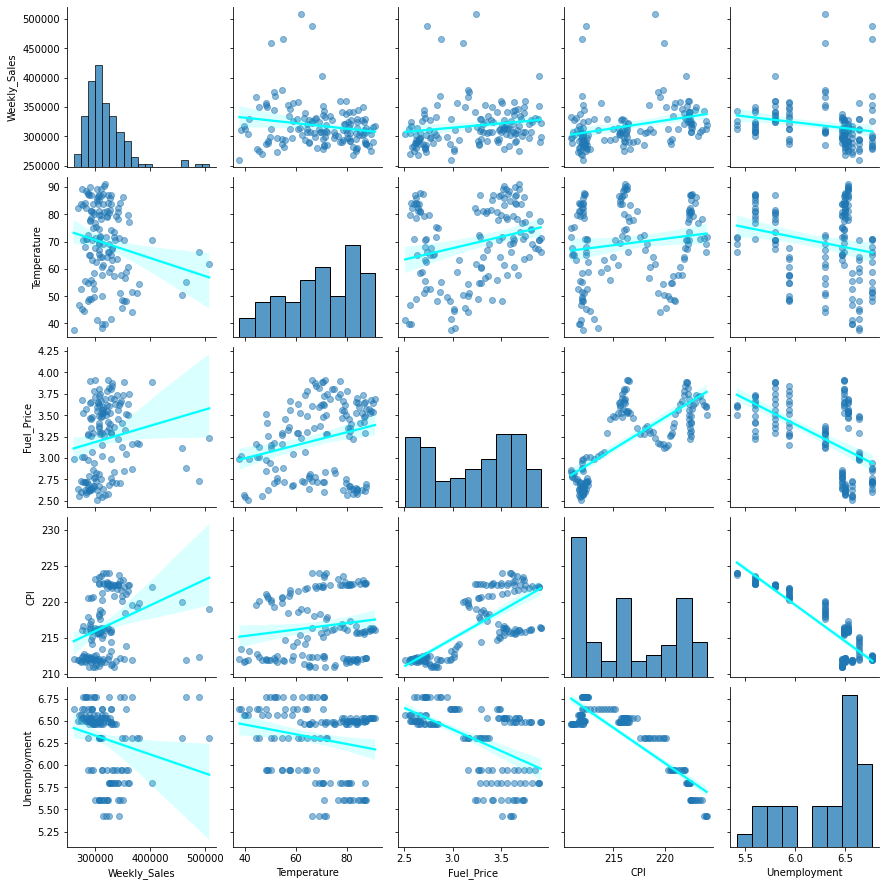

In [ ]:
store = 5
plot_by_store(store)

Another store:

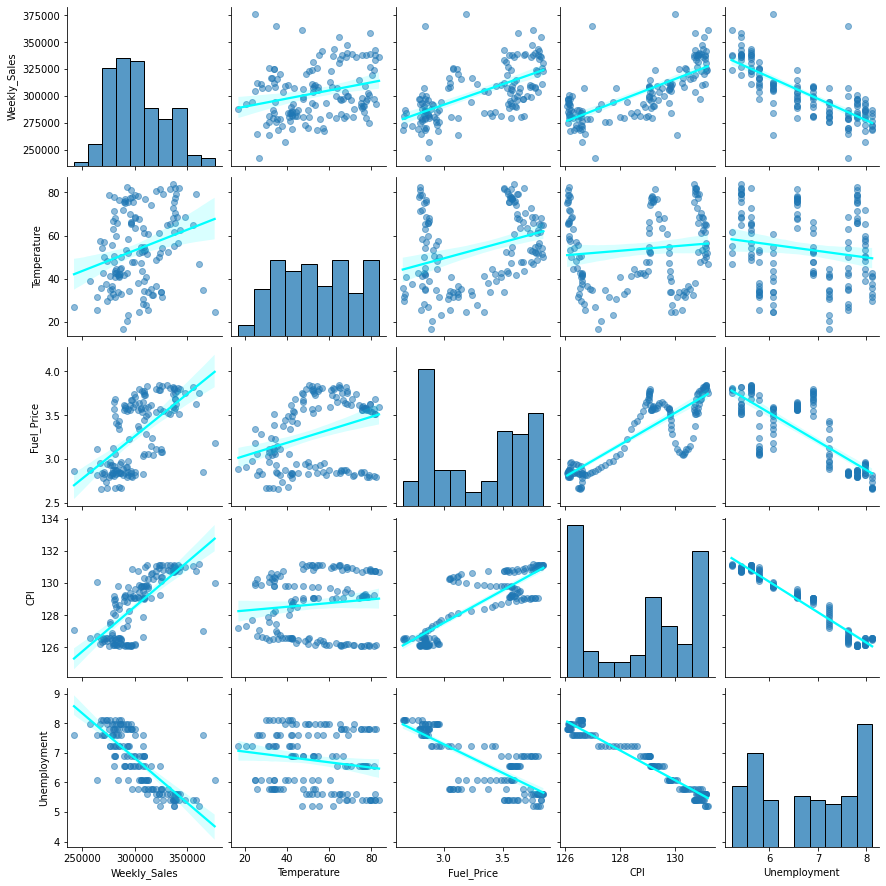

In [ ]:
store = 44
plot_by_store(store)

### 01.2 Clean the data

#### 01.2.1 Checking for null values

<br>

**Compute Ratio**

$$ R_{m} = \frac{Number \, of \, missing \, values}{ Total \, number \, of \, values} $$

<br>

In this step, a verification of NaN values must be done. According to the previous formula, if the $R_{m}$ is too high, it is recommended to delete the entire column. If $R_{m}$ is low, it is recommended to fill NaN values with the mean, median or most frequent value.

In [ ]:
dataset.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

There are no null values in this dataset. If this is correct, applying the previous formula will show a $R_{m} = 0$ for each numerical feature.

In [ ]:
def compute_ratio(dataset, columns):
  """
  Computes the ratio of missing values.

  Parameters
  ---------
  dataframe: Pandas DataFrame
    dataset
  colums: list
    array names of columns.

  Returns
  ----------
  dataframe: Pandas DataFrame
    a dataset with compute ratio for each feature
  """

  Rms = {}
  for col in columns:
    Rm = dataset[col].isnull().sum() / dataset[col].count()
    Rms[col] = Rm

  Rms = pd.DataFrame(Rms.items(), columns=['Feature', 'Rm'])

  return Rms 

In [ ]:
Rms = compute_ratio(dataset, ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'])
Rms

,Feature,Rm
0,Weekly_Sales,0.0
1,Temperature,0.0
2,Fuel_Price,0.0
3,CPI,0.0
4,Unemployment,0.0


As is shown, the dataset does not contain NaN values in the features. Now it is possible to evaluate and remove some outliers.

01.2.2 Removing outliers

A function is defined to remove outliers in the dataset. 

In [ ]:
def remove_outliers(dataframe, columns, nsd):
  """
  Revome outliers from a given dataset.

  Parameters
  ---------
  dataframe: Pandas DataFrame
    dataset
  colums: list
    array names of columns.
  nsd: int
    number of standar deviation.

  Returns
  ----------
  dataframe: Pandas DataFrame
    a dataset without outliers
  """
  for col in columns:
    
    mean = dataframe[col].mean()
    sd = dataframe[col].std()
    dataframe = dataframe[dataframe[col] < mean + (nsd * sd)]

  return dataframe



The previously defined method is applied to eliminate the outliers. Generally, three standard deviations is used, which means 0.3% of the outliers are removed from the dataset.

In [ ]:
num_std = 3
dataset_wo_outliers = remove_outliers(dataset, ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI',	'Unemployment'], num_std)
new_number_row, new_number_columns = dataset_wo_outliers.shape
print(f'The original dataset has {number_row} rows and {number_columns} columns.')
print(f'The dataset without outliers has {new_number_row} rows and {new_number_columns} columns.')

The original dataset has 6435 row and 8 columns.
The dataset without outliers has 6186 row and 8 columns.


The following bar chart helps to see how some outliers values were deleted from the dataset, especially those months of December.

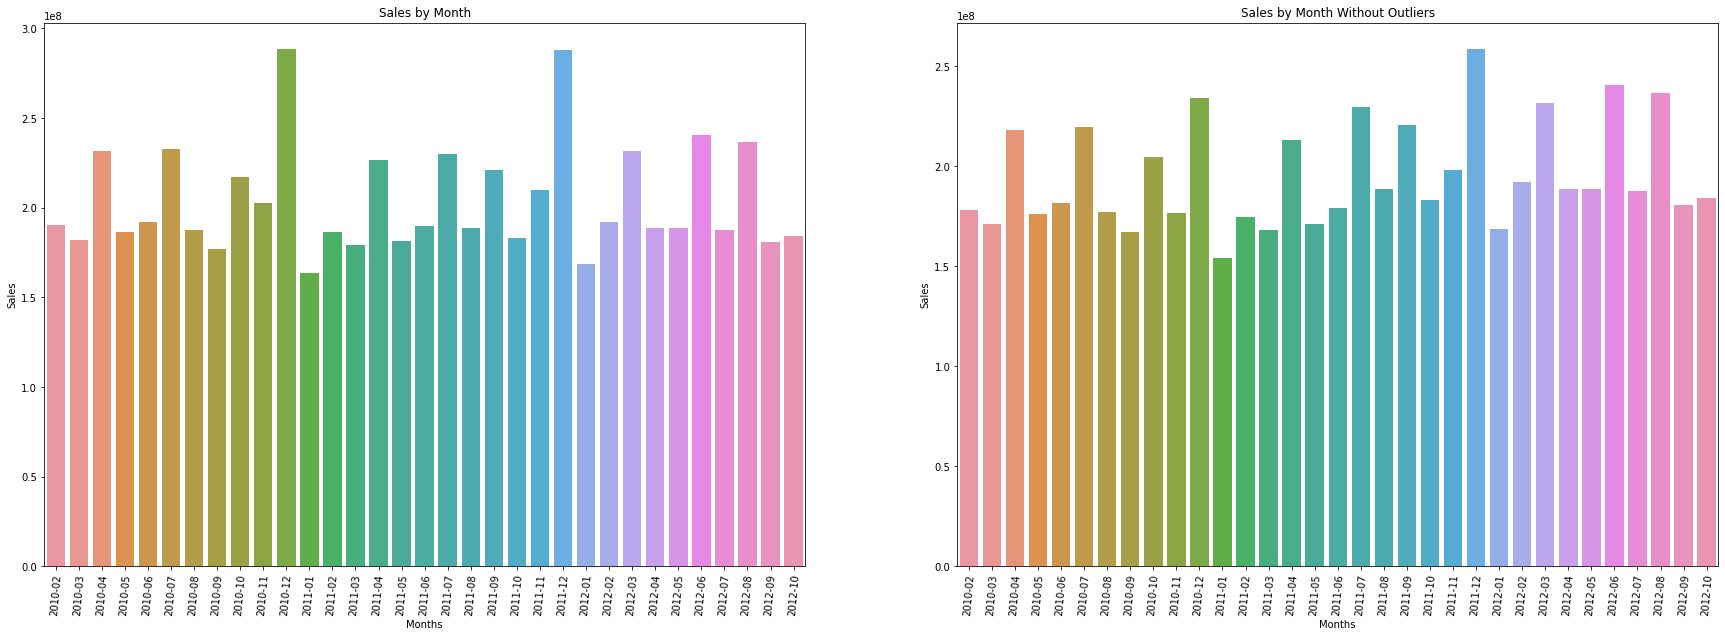

In [ ]:
dataset_wo_outliers_month = dataset_wo_outliers.groupby([dataset_wo_outliers.Date.dt.to_period('M')])['Weekly_Sales'].sum()
dataset_wo_outliers_month = pd.DataFrame(dataset_wo_outliers_month)
dataset_wo_outliers_month = dataset_wo_outliers_month.reset_index()

fig, axes = plt.subplots(1, 2, figsize=(30, 10))

sns.barplot(ax=axes[0], data=monthly_sales, x='Date', y='Weekly_Sales')
axes[0].set_title('Sales by Month')
axes[0].set_xlabel('Months')
axes[0].set_ylabel('Sales')
axes[0].tick_params(axis='x', labelrotation=85)

sns.barplot(ax=axes[1], data=dataset_wo_outliers_month, x='Date', y='Weekly_Sales')
axes[1].set_title('Sales by Month Without Outliers')
axes[1].set_xlabel('Months')
axes[1].set_ylabel('Sales')
axes[1].tick_params(axis='x', labelrotation=85)


plt.show()

### 01.3 Format the data

In the beginning, when the data was loaded, the 'Date' field was formatted to manipulate and filter the data between months and years. Other fields do not need to change their format. For example, the feature 'Holiday_Flag' is already encoded.

## 02 Feature Engineering

### 02.1 Feature Construction

Feature construction is implemented in the section **05 Performance Improvement** to evaluate if the performance improves by creating new fields summing two and four previous weeks from the weekly sales and evaluating it through Relevant Feature Elimination (RFE) to see if these new features provide more meaningful information for the model, and consequently improve the predictions.


### 02.2 Feature Transformation
The field Date is transformed into a timestamp number; this makes it possible to work with data in the model as a numerical value. Also, the fields have values that vary in scale, so a StandardScaler is used.

In [ ]:
dataset['Date'] = dataset['Date'].map(datetime.datetime.toordinal)
number_of_sd = 3
dataset = remove_outliers(dataset, ['Store', 'Date', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], number_of_sd)

X = dataset[['Store', 'Date', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
y = dataset['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### 02.3 Dimension Reduction

A Recursive Feature Elimination is applied to the dataset. This technique helps to select the more relevant features from the dataset by giving a weight to each feature and applying a model recursively, in this case, a Linear Regression model, then selecting those features that represent more meaning to the model.

In [ ]:
from numpy import array

regr = LinearRegression()
selector = RFE(regr, n_features_to_select=5)
selector = selector.fit(X_train, y_train)

filter = selector.support_
ranking = selector.ranking_

features = array(['Store', 'Date', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'])
print('Selected features:')
print(features[filter])

Selected features:
['Store' 'Date' 'Temperature' 'CPI' 'Unemployment']


The meaningful features selected in this iteration are: 'Store,' 'Date,' 'Temperature,' 'CPI,' and 'Unemployment.'

## 03 Data Modeling

Because this is a prediction of a sales problem, a Linear Regression model is chosen. This supervised model works appropriately for this type of prediction. In the following code, the selected features are stored as the features (X), and the target is identified as the Weekly_Sales (y). And a split of the data is applied, reserving 30% to test the model then.

### 03.1 Linear Regression Model

In [ ]:
X = dataset[['Store', 'Date', 'Temperature', 'CPI', 'Unemployment']]
y = dataset['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

regr = LinearRegression()
regr.fit(X_train, y_train)

print("Interceptor value: ", regr.intercept_)
print("Slope or coefficient value: ", regr.coef_)

Interceptor value:  1045556.8153114178
Slope or coefficient value:  [-201698.95768294   -8700.79585991  -15525.69016177  -89095.09177356
  -19884.73586219]


The model is trained:

In [ ]:
y_pred = regr.predict(X_test)

## 04 Performance Measure

### 04.1 Predict values
Three main metrics are used to evaluate the model's performance. All these metrics add the difference between actual and predicted values (errors) and get their mean. MAE does not consider the negative values, only the absolute ones, so it does not accurately represent the error. MSE considers the negative values, but because it squares the errors, it gives a too-scaled value. RMSE resolves the MSE issue by applying the square root to the sum of differences, which is regarded as more accurate. In this case, the predicted values using this model have a margin of error of $533299.46 up or down, which is significant, so the model does not perform well according to RMSE.

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: { mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 438945.32
Mean Squared Error: 284408313354.45
Root Mean Squared Error: 533299.46


### 04.2 Compare predicted values

In [ ]:
comparison = pd.DataFrame({'Actual': y_test.squeeze(),
                           'Predicted': y_pred.squeeze()})

comparison

,Actual,Predicted
4298,1357600.68,8.419100e+05
3096,1007579.44,1.140152e+06
6233,303974.28,8.292461e+05
5841,1374891.36,7.214000e+05
1250,658965.05,1.179603e+06
...,...,...
1009,914500.91,1.215976e+06
131,1592409.97,1.250633e+06
3405,1194334.65,1.094387e+06
4036,463752.89,1.016715e+06


The data plotted in this scatter graph represent the actual and predicted values. As is shown, the model is not precise in predicting extreme values.

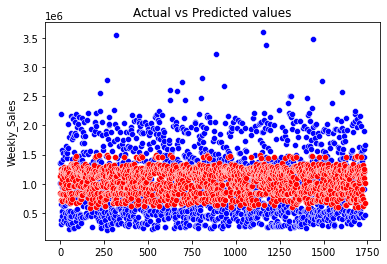

In [ ]:
sns.scatterplot(x=range(len(y_test)), y=y_test, color='blue')
sns.scatterplot(x=range(len(y_pred)), y=y_pred, color='red')
plt.title("Actual vs Predicted values")
plt.show()

## 05 Performance Improvement

To improve the performance, some experimentation was made by creating new fields that sum sales from the previous two and four weeks by each record to evaluate if they provide additional meaningful features and help the model to perform better. Also, the months of December were removed because they represent anomalous behaviour, showing peaks in sales during that month each year. Each step is applied in this new iteration giving the best results.

In [ ]:
url = 'https://raw.githubusercontent.com/bascr/walmart-sales/main/dataset/walmart-sales.csv'
dataset = pd.read_csv(url)
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%d-%m-%Y')
dataset

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667


In [ ]:
def getPreviousCumulativeSales(data, number_of_weeks, field_name):
    """
    Sums the Weekly Sales previous numbers of weeks indicated in 
    the number_of weeks_parameter. The process sums the weeks by stores
    and before doing the addition it orders the records in a decendend way.
    Then it concats all the stores in a unified dataet.

    Parameters
    ---------

    data: Pandas Dataframe
      Dataset to modify
    
    number_of_weeks: int
      Previous number of weeks to consider to addition
    
    field_name: str
      Number of the new field that contains the sum of previous weeks

    Returns
    ---------

    Dataframe with the new field
    """
    ds = data.copy(deep=True)
    stores = list(range(ds['Store'].min(), ds['Store'].max() + 1))

    process_data = []

    for i in stores:
      data_store = dataset[dataset['Store'] == i]
      data_store.sort_values(by='Date', ascending=False, inplace=True)
      data_store[field_name] = data_store['Weekly_Sales'].rolling(number_of_weeks).sum().shift(-1 * number_of_weeks)

      process_data.append(data_store)

    process_data = pd.concat(process_data)

    
    return process_data

dataset = getPreviousCumulativeSales(dataset, 2, 'Sales2WB')
dataset = getPreviousCumulativeSales(dataset, 4, 'Sales4WB')
dataset

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Sales2WB,Sales4WB
142,1,2012-10-26,1493659.74,0,69.16,3.506,223.444251,6.573,3081141.58,6188986.81
141,1,2012-10-19,1508068.77,0,67.97,3.594,223.425723,6.573,3243858.78,6187044.10
140,1,2012-10-12,1573072.81,0,62.99,3.601,223.381296,6.573,3107845.23,6131400.16
139,1,2012-10-05,1670785.97,0,68.55,3.617,223.181477,6.573,2943185.32,6122381.52
138,1,2012-09-28,1437059.26,0,76.08,3.666,222.981658,6.908,3023554.93,6267405.66
...,...,...,...,...,...,...,...,...,...,...
6296,45,2010-03-05,777951.22,0,37.13,2.777,182.120157,8.992,1583155.69,3130833.84
6295,45,2010-02-26,741891.65,0,34.89,2.754,182.077469,8.992,1498252.68,NaN
6294,45,2010-02-19,841264.04,0,31.27,2.745,182.034782,8.992,1547678.15,NaN
6293,45,2010-02-12,656988.64,1,27.73,2.773,181.982317,8.992,NaN,NaN


In [ ]:
dataset.isnull().sum()

Store             0
Date              0
Weekly_Sales      0
Holiday_Flag      0
Temperature       0
Fuel_Price        0
CPI               0
Unemployment      0
Sales2WB         90
Sales4WB        180
dtype: int64

In [ ]:
Rms = compute_ratio(dataset, ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Sales2WB', 'Sales4WB'])
Rms

,Feature,Rm
0,Weekly_Sales,0.000000
1,Temperature,0.000000
2,Fuel_Price,0.000000
3,CPI,0.000000
4,Unemployment,0.000000
5,Sales2WB,0.014184
6,Sales4WB,0.028777


In [ ]:
dataset['Sales2WB'] = dataset['Sales2WB'].fillna(dataset['Sales2WB'].mean())
dataset['Sales4WB'] = dataset['Sales4WB'].fillna(dataset['Sales4WB'].mean())

Rms = compute_ratio(dataset, ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Sales2WB', 'Sales4WB'])
Rms

,Feature,Rm
0,Weekly_Sales,0.0
1,Temperature,0.0
2,Fuel_Price,0.0
3,CPI,0.0
4,Unemployment,0.0
5,Sales2WB,0.0
6,Sales4WB,0.0


In [ ]:
dataset = dataset[dataset['Date'].dt.month != 12]
number_of_features=6
number_of_sd = 3

dataset['Date'] = dataset['Date'].map(datetime.datetime.toordinal)

dataset = remove_outliers(dataset, ['Store', 'Date', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Sales2WB', 'Sales4WB'], number_of_sd)

X = dataset[['Store', 'Date', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Sales2WB', 'Sales4WB']]
y = dataset['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

regr = LinearRegression()
selector = RFE(regr, n_features_to_select=number_of_features)
selector = selector.fit(X_train, y_train)

filter = selector.support_
ranking = selector.ranking_

features = array(['Store', 'Date', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Sales2WB', 'Sales4WB'])
print('Selected features:')
print(features[filter])

Selected features:
['Store' 'Date' 'Temperature' 'Fuel_Price' 'Sales2WB' 'Sales4WB']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
X = dataset[['Store', 'Date', 'Temperature', 'Fuel_Price', 'Sales2WB', 'Sales4WB']]
y = dataset['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

regr = LinearRegression()
regr.fit(X_train, y_train)

print("Interceptor value: ", regr.intercept_)
print("Slope or coefficient value: ", regr.coef_)

Interceptor value:  1025295.4105557017
Slope or coefficient value:  [ -5681.60690941 -11778.64638219   4728.92170737  10525.27703558
 457694.73847495  65792.73812832]


In [ ]:
y_pred = regr.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: { mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 61139.46
Mean Squared Error: 9974881883.94
Root Mean Squared Error: 99874.33


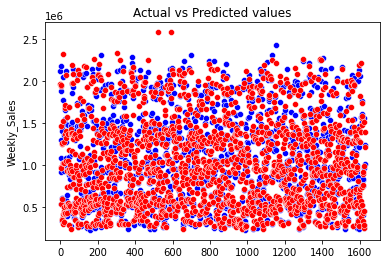

In [ ]:
sns.scatterplot(x=range(len(y_test)), y=y_test, color='blue')
sns.scatterplot(x=range(len(y_pred)), y=y_pred, color='red')
plt.title("Actual vs Predicted values")
plt.show()

## Conclusion

- The fields that help to predict better the weekly sales are Store, Date, Temperature, Fuel_Price, Sales2WB, and Sales4WB. The temperature and Fuel price, as the scatterplot at the beginning, showed a linear relationship, confirming this relevance as external factors to predict better results; As the RFE measured it, these are the meaningful features in predicting weekly sales.
- Adding new fields summing data from the previous two and four weeks' sales for each record (Sales2WB, Sales4WB) and selecting more relevant features using Recursing Feature Elimination (RFE) improved the model from an RSME of 533299.46 to an RSME of 99874.33. This means the model will predict values with an error of $99874.33 up or down, diminishing the margin of error to 81.27%.
- The model also predicts better if months corresponding to December were removed because these months have outliers; in this month, the sales peak yearly.